In [15]:
'''
run to install required packages\liraries
!pip install scikit-learn
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install yfinance
'''

#import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import yfinance as yf

In [16]:
'''
download data from yahoo finance, drop useless columns,
make Target-i columns, where i is the number of days prior to current target closing price
'''
data = yf.download(tickers = 'ATVI', start = '2003-07-29',end = '2023-07-29')
for i in range(5, 0, -1):
    data[f'Target-{i}'] = data['Close'].shift(i)
data['Target'] = data['Close']
data.drop(['Volume', 'Close', 'High', 'Low', 'Open', 'Adj Close'], axis=1, inplace=True)
data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [17]:
'''
standartization is used due to the closing prices being relatively low in the beginning of the data
compared to the prices at the end of the data
'''
from sklearn.preprocessing import StandardScaler
#z = (x - u) / s, where u - mean, s - standart deviation
sc = StandardScaler()
col_names = list(data.columns)
data_scaled = pd.DataFrame(sc.fit_transform(data), columns = col_names)
data_scaled.index = data.index
data_scaled 

,Target-5,Target-4,Target-3,Target-2,Target-1,Target
Date,,,,,,
2003-08-05,-1.063436,-1.065104,-1.064580,-1.065384,-1.066060,-1.067728
2003-08-06,-1.064831,-1.064307,-1.065111,-1.065782,-1.067453,-1.067728
2003-08-07,-1.064034,-1.064838,-1.065509,-1.067175,-1.067453,-1.068855
2003-08-08,-1.064565,-1.065237,-1.066903,-1.067175,-1.068580,-1.069186
2003-08-11,-1.064963,-1.066630,-1.066903,-1.068303,-1.068912,-1.068192
...,...,...,...,...,...,...
2023-07-24,2.158723,2.140713,2.120233,2.122058,2.107282,2.128563
2023-07-25,2.142078,2.121596,2.123418,2.108615,2.129916,2.134926
2023-07-26,2.122955,2.124783,2.109970,2.131257,2.136282,2.132805


In [18]:
data_set = (data_scaled.iloc[:, 0:6]).to_numpy()
middle_matrix = data_set[:, :-1]
X = middle_matrix.reshape((len(data), middle_matrix.shape[1], 1))
Y = data_set[:, -1]

In [19]:
#train-test split
train = int(len(X)*0.8)
val = int(len(X)*0.1)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([layers.Input((5, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mse'])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

In [21]:
blizz = model.fit(X[:train], Y[:train], validation_data=(X[train:(val+train)], Y[train:(val+train)]), epochs=300, callbacks=[early_stopping_callback])

Epoch 1/300
126/126 [==============================] - 4s 10ms/step - loss: 0.4277 - mse: 0.4277 - val_loss: 1.2516 - val_mse: 1.2516
Epoch 2/300
126/126 [==============================] - 1s 6ms/step - loss: 0.0900 - mse: 0.0900 - val_loss: 0.1099 - val_mse: 0.1099
Epoch 3/300
126/126 [==============================] - 1s 5ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0211 - val_mse: 0.0211
Epoch 4/300
126/126 [==============================] - 1s 6ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0217 - val_mse: 0.0217
Epoch 5/300
126/126 [==============================] - 1s 5ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 6/300
126/126 [==============================] - 1s 7ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0194 - val_mse: 0.0194
Epoch 7/300
126/126 [==============================] - 1s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 8/300
126/126 [==============================] - 1s 6ms/step -

In [22]:
tmp = sc.inverse_transform(data_scaled)
#invese_transformed target column for prediction range
actual = pd.DataFrame(tmp[train+val:], columns = col_names)
actual.index = data.index[train+val:]
actual.drop(['Target-5', 'Target-4', 'Target-3', 'Target-2', 'Target-1'], axis=1, inplace=True)

In [23]:
Y_pred = model.predict(X[val+train:]).flatten()
#inverse_transform for predictions
for i in range(len(Y_pred)):
    Y_pred[i] = Y_pred[i]*np.sqrt(sc.var_[-1]) + sc.mean_[-1]

16/16 [==============================] - 1s 4ms/step


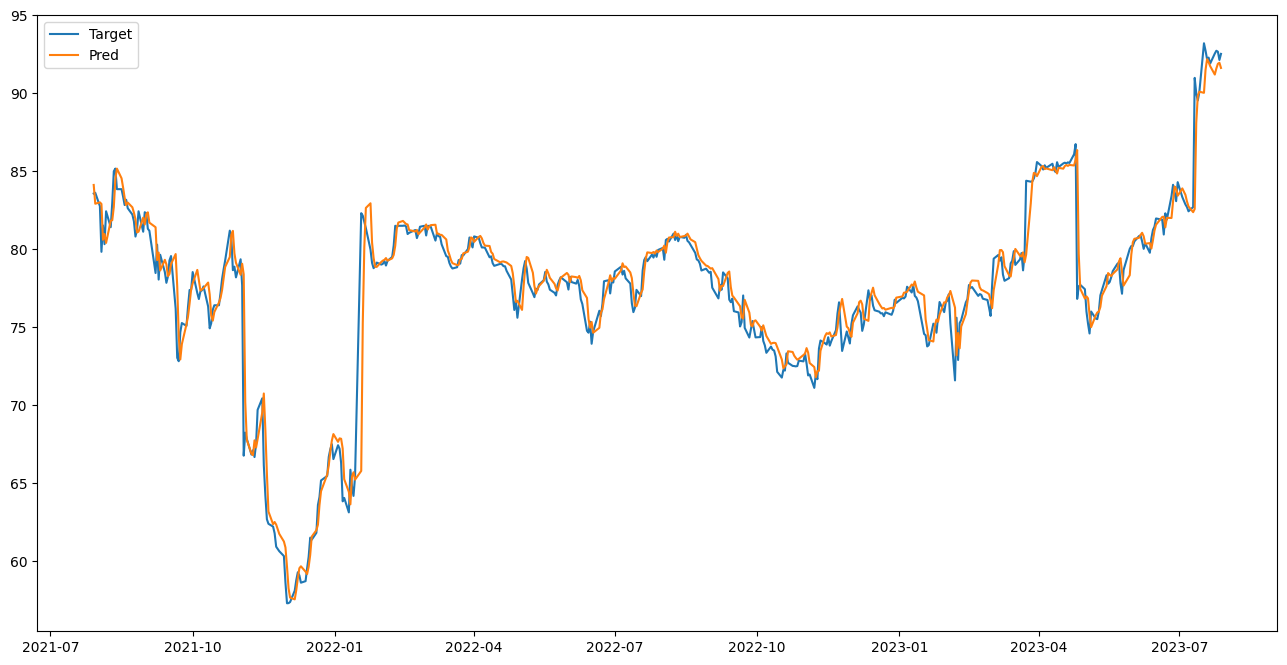

In [24]:
plt.figure(figsize=(16,8))
plt.plot(actual.index, actual['Target'])
plt.plot(actual.index, Y_pred)
plt.legend(['Target', 'Pred'])

In [25]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(actual['Target'], Y_pred))

1.5057284398652175 2.267218134618942


In [26]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(actual['Target'], Y_pred)

0.010874259827357688

In [27]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(actual['Target'], Y_pred)

0.8252052018941042

In [28]:
'''
this shows that an actual predictive accuracy of the model is relatively low,
despite pretty good error metrics calculated above
'''
actual['TargetTrend'] = actual['Target'] - actual['Target'].shift(-1)
actual['TargetTrendBinary'] = [1 if actual.TargetTrend[i]>0 else 0 for i in range(len(actual))]
prediction = pd.DataFrame(Y_pred[:], columns = ['Target'])
prediction.index = actual.index
prediction['TargetTrend'] = prediction['Target'] - prediction['Target'].shift(-1)
prediction['TargetTrendBinary'] = [1 if prediction.TargetTrend[i]>0 else 0 for i in range(len(prediction))]
prediction.dropna(inplace=True)
actual.dropna(inplace=True)

In [29]:
count = 0
for i in range(len(actual)):
    if prediction['TargetTrendBinary'][i] == actual['TargetTrendBinary'][i]:
        count+=1
print(count/len(actual)*100)

48.60557768924303
